In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stat
import scipy.io as scipio
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
## read train & test data
data_train = pd.DataFrame(pd.read_csv("data_train.csv"))
data_test = pd.DataFrame(pd.read_csv("data_test.csv"))
data_train = data_train.dropna(0)
data_test = data_test.dropna(0)

## index by visit_date column 
## the dates are not unique yet
data_train = data_train.set_index("visit_date", drop=True)
data_test = data_test.set_index("visit_date", drop=True)

## convert the dates from string to datetime
arima_dates_train = pd.Series(data_train.index.values).\
apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
arima_dates_test = pd.Series(data_test.index.values).\
apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

## get the unique date index for full data
data = pd.concat([data_train,data_test],0)
arima_dates_full = pd.Series(data.index.values).\
apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

## Train-Val Split

In [4]:
import os
## leave out Feb 2017 data for each restaurant df 
## as validation split
def train_val_split(path):
    """Takes as input a directory, splits all the training csv 
    files in the directory as training and validation, appends the 
    dataframes to separate dictionaries, where keys are rest ids"""
    train_dict = {}
    val_dict = {}
    for rest_file in os.listdir(path):
        data = pd.DataFrame(pd.read_csv(path + rest_file))
        data = data.set_index("visit_date",drop=True)
        ## convert index to datetime to filter
        data.index = pd.Series(data.index).\
        apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
        ## filter the records before 2017-02-01 for training
        data_train = data[data.index<datetime.strptime("2017-02-01", "%Y-%m-%d")]
        ## filter the records after 2017-02-01 for validation
        data_val = data[data.index>=datetime.strptime("2017-02-01", "%Y-%m-%d")]
        ## return two datasets: training and validation
        train_dict[rest_file] = data_train
        val_dict[rest_file] = data_val
    return train_dict, val_dict

In [5]:
path = "arima_rest_data/train/"
train_dict, val_dict = train_val_split(path)[0], train_val_split(path)[1]

In [8]:
endog_col = ["visitors"]
exog_col = ['Friday', 'Monday', 'Saturday','Sunday', 'Thursday', 
            'Tuesday', 'Wednesday','avg_temperature1','high_temperature1', 
            'holiday_flg', 'hours_sunlight1','low_temperature1',
           'total_area_visitors', 'total_genre_visitors']

## Grid Search

In [11]:
os.listdir("arima_rest_data/train/")[5]
try_data = train_dict["air_03963426c9312048.csv"]
val_try = val_dict["air_03963426c9312048.csv"]

In [20]:
sarimax_model = SARIMAX(endog=try_data[endog_col],exog=try_data[exog_col],
                       order=(7,1,7),seasonal_order=(7,0,7,10),trend="n",
                       mle_regression=True)

params = sarimax_model.fit(maxiter=1000,disp=True,return_params=True,full_output=True)
# sarimax_model.loglike(sarimax_model.fit(maxiter=1000,return_params=True,full_output=True))
# sarimax_model.loglike(params)

/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [121]:
fit_cov_types = ["opg","oim","approx","robust","robust_approx","none"]
fit_methods = ["newton","bfgs","lbfgs","powell","cg","ncg","basinhopping"]

In [240]:
## manual param grid
import itertools

order_p = np.array([1,7])
order_d = np.arange(1,3) ## order of differencing
order_q = np.array([1,7])
s_order_p = np.array([1,7])
s_order_d = np.arange(1,3) ## order of seasonal differencing
s_order_q = np.array([1,7])
s_order_s = np.array([4,1]) ## seasons per year
param_trend = ["n","c"]

grid_lists = [order_p, order_d, order_q, s_order_p, s_order_d,\
             s_order_q, s_order_s, param_trend]

grid = list(itertools.product(*grid_lists))

In [13]:
endog_col = ["visitors"]
exog_col = ['Friday', 'Monday', 'Saturday','Sunday', 'Thursday', 
            'Tuesday', 'Wednesday','avg_temperature1','high_temperature1', 
            'holiday_flg', 'hours_sunlight1','low_temperature1',
           'total_area_visitors', 'total_genre_visitors']

In [61]:
# os.listdir("arima_rest_data/train/")
# grid_model_params = {}

In [279]:
grid = list(itertools.product(*grid_lists))
## delete from directory
# air_28dbe91c4c9656be.csv
# air_2a485b92210c98b5.csv

# grid_model_params = {}
for params in grid:
    print (params)
    ## will average the learned parameters of all 
    ## the restaurants for every set of parameter 
    ## then will pass them to the prediction function
    ## as start params
    grid_model_params[params] = {}
    ## select 150 random restaurants
    for rest in [os.listdir("arima_rest_data/train/")[1:][ix] for ix in \
                 [np.random.choice(665) for x in range(10)]]:
        print (str(rest))
        ## train_dict: previously written training dictionary of all rests 
        data = train_dict[rest]
        if "total_area_visitors" not in data.columns.values or "total_genre_visitors" not in data.columns.values:
            None
        elif data[exog_col].shape[0]<2 or data[exog_col].shape[1]<8\
        or len(data[endog_col])<8: 
            None
        ## params_exog = np.linalg.pinv(exog).dot(endog)
        elif data[endog_col].shape[0] < 1 or data[endog_col].shape[1] < 1:
            None
        elif len((np.linalg.pinv(data[exog_col]).dot(data[endog_col])).shape) < 2: 
            None
        # endog = endog - np.dot(exog, params_exog)
        elif np.dot(data[exog_col], np.linalg.pinv(data[exog_col]).dot(data[endog_col])).shape[0]<1\
        or np.dot(data[exog_col], np.linalg.pinv(data[exog_col]).dot(data[endog_col])).shape[1]<1:
            None
        elif rest == "air_28dbe91c4c9656be.csv":
            None
        elif rest == "air_4dea8d17f6f59c56.csv":
            None
        elif rest == ".ipynb_checkpoints":
            None
        else:
            sarimax_model = SARIMAX(endog=data[endog_col],exog=data[exog_col],\
                           order=(int(params[0]),int(params[1]),int(params[2])),seasonal_order=(int(params[3]),int(params[4]),int(params[5]),int(params[6])),\
                                    trend=params[7], mle_regression=True, enforce_invertibility=False)

            grid_model_params[params][rest] = sarimax_model.fit(maxiter=1000,disp=True,return_params=True,full_output=True)
        

In [403]:
def loss_mape(true, pred):
    """args:
    - true: the true array of "visitor" numbers 
            for the determined timeframe - shape: (n_days,)
    - pred: the predicted array of "visitor" numbers
            for the determined timeframe - shape: (n_days,)
       returns:
    - avg_percent_error: average percentage error in terms
                        of visitors"""
    abs_error = np.abs(np.subtract(true,pred))
    loss = np.divide(abs_error,true)
    avg_percent_error = np.mean(loss)
    return avg_percent_error

In [281]:
def loss_squared(true, pred):
    """args:
    - true: the true array of "visitor" numbers 
            for the determined timeframe - shape: (n_days,)
    - pred: the predicted array of "visitor" numbers
            for the determined timeframe - shape: (n_days,)
       returns:
    - avg_square_error: average squared error in terms
                        of visitors, averaged by the number
                        of days"""
    num_days = len(true)
    sq_error = np.square(np.array(true-pred))
    avg_square_error = (1/num_days)*np.sum(sq_error)
    return avg_square_error

In [243]:
grid_search_iters = {}

In [463]:
np.random.choice(os.listdir("arima_rest_data/train/"),3)

array(['air_675aa35cba456fd1.csv', 'air_0867f7bebad6a649.csv',
       'air_7cf5a02c0e01b647.csv'], 
      dtype='<U24')

In [667]:
class SARIMAXGridSearch(object):
    def __init__(self, param_grid=grid, rest_dir="arima_rest_data/train/",\
                 num_rests=10, len_rests=600):
        
        self.param_grid = param_grid
        self.rest_dir = rest_dir
        self.num_rests = num_rests
        self.len_rests = len_rests
        
    def select_setting(self, grid_index):
        
        ## n = int index of param_grid
        param_grid = self.param_grid
        rest_dir = self.rest_dir
        num_rests = self.num_rests
        len_rests = self.len_rests
        ## grid settings
        params = param_grid[grid_index]
        rests = [os.listdir(rest_dir)[1:][ix] for ix in \
                 [np.random.choice(len_rests) for x in range(num_rests)]]
        
        self.params = params
        self.rests = rests
        return self
    
    def averaging_fit(self):
        params = self.params
        rests = self.rests
        model_params = {}
        
        if len(rests) == 1:
            if "total_area_visitors" not in train_dict[rests[0]].columns.values or\
            "total_genre_visitors" not in train_dict[rests[0]].columns.values:
                pass
            elif train_dict[rests[0]].shape[0] < 24 and val_dict[rests[0]].shape[0] < 8:
                pass
            else:
                data = train_dict[rest]
                val_data = val_dict[rest]
                sarimax_model = SARIMAX(endog=data[endog_col],exog=data[exog_col],\
                                   order=(int(params[0]),int(params[1]),int(params[2])),\
                                            seasonal_order=(int(params[3]),int(params[4]),\
                                                            int(params[5]),int(params[6])),\
                                            trend=params[7], mle_regression=True, \
                                            enforce_invertibility=False)
                results_object = sarimax_model.fit(maxiter=1000,method="bfgs")
                self.results_object = results_object

        else:
            rest_params = []
            for rest_ix in range(len(rests)):
                if "total_area_visitors" not in train_dict[rests[rest_ix]].columns.values or\
                "total_genre_visitors" not in train_dict[rests[rest_ix]].columns.values:
                    continue
                elif train_dict[rests[rest_ix]].shape[0] < 24 and val_dict[rests[rest_ix]].shape[0] < 24:
                    continue
                else:
                    data = train_dict[rests[rest_ix]]
                    sarimax_model = SARIMAX(endog=data[endog_col],exog=data[exog_col],\
                                   order=(int(params[0]),int(params[1]),int(params[2])),\
                                            seasonal_order=(int(params[3]),int(params[4]),\
                                                            int(params[5]),int(params[6])),\
                                            trend=params[7], mle_regression=True, \
                                            enforce_invertibility=False)
                    results_object = sarimax_model.fit(start_params=None,maxiter=1000,method="bfgs",\
                                                          return_params=True)
                    rest_params.append(results_object)
                    final_start_params = np.mean(rest_params,0)
            self.average_params = final_start_params
        return self
    
    def bag_pred(self):
        rests = self.rests
        params = self.params
        average_params = self.average_params
        rest_preds = {}
        for rest in rests:
            data = train_dict[rest]
            val_data = val_dict[rest]
            print (rest)
            sarimax_model = SARIMAX(endog=data[endog_col],exog=data[exog_col],\
                               order=(int(params[0]),int(params[1]),int(params[2])),\
                                        seasonal_order=(int(params[3]),int(params[4]),\
                                                        int(params[5]),int(params[6])),\
                                        trend=params[7], mle_regression=True, \
                                        enforce_invertibility=False,time_varying_regression=False)
            final_model = sarimax_model.fit(start_params=average_params,\
                                              maxiter=1000,method="bfgs")
            bag_preds_ = final_model.predict\
                    (start=len(data)-1, end=len(data)+len(val_data)-1,dynamic=True,\
                    exog=val_data[exog_col])
            rest_preds[rest] = bag_preds_
            
        self.preds = rest_preds
        return self, rest_preds
    
    def bag_losses(self):
        rests = self.rests
        params = self.params
        average_params = self.average_params
        preds = self.preds
        bagged_rest_scores = {}
        for rest in self.rests:
            val_data = val_dict[rest]
            pred = preds[rest]
            true = np.array(val_data["visitors"])
            abs_percent_loss = loss_mape(true,pred[:len(true)])
            square_loss = loss_squared(true,pred[:len(true)])
            bagged_rest_scores[rest] = [abs_percent_loss,square_loss] 
        return bagged_rest_scores
    
    def iterative_fit(self):
        ### param yazdirabildigimize gore, ortalama almali yapabilriiz
        ## !!!!!!!!!!! yay 
        ## bir de tekrar fit etmemeli yazmaya calis
        params = self.params
        rests = self.rests
        model_params = {}
        
        if len(rests) == 1:
            data = train_dict[rest]
            val_data = val_dict[rest]
            sarimax_model = SARIMAX(endog=data[endog_col],exog=data[exog_col],\
                               order=(int(params[0]),int(params[1]),int(params[2])),\
                                        seasonal_order=(int(params[3]),int(params[4]),\
                                                        int(params[5]),int(params[6])),\
                                        trend=params[7], mle_regression=True, \
                                        enforce_invertibility=False)
            
            results_object = sarimax_model.fit(maxiter=1000,method="bfgs")
            self.results_object = results_object
        else:
            for rest_ix in range(len(rests)):
                if "total_area_visitors" not in train_dict[rests[rest_ix]].columns.values or\
                "total_genre_visitors" not in train_dict[rests[rest_ix]].columns.values:
                    continue
                elif train_dict[rests[rest_ix]].shape[0] < 24 and val_dict[rests[rest_ix]].shape[0] < 24:
                    continue
                else:
                    data = train_dict[rests[rest_ix]]
                    val_data = val_dict[rests[rest_ix]]
                    sarimax_model = SARIMAX(endog=data[endog_col],exog=data[exog_col],\
                                   order=(int(params[0]),int(params[1]),int(params[2])),\
                                            seasonal_order=(int(params[3]),int(params[4]),\
                                                            int(params[5]),int(params[6])),\
                                            trend=params[7], mle_regression=True, \
                                            enforce_invertibility=False)
                    if rest_ix == 0:
                        results_object = sarimax_model.fit(start_params=None,maxiter=1000,method="bfgs",\
                                                          return_params=True)
                        model_params[rests[rest_ix]] = results_object
                    elif rest_ix != 0 and rest_ix < len(rests)-1:
                        results_object = sarimax_model.fit(start_params=model_params[rests[rest_ix-1]],maxiter=1000,method="bfgs",\
                                                          return_params=True)
                        model_params[rests[rest_ix]] = results_object
                    elif rest_ix == len(rests)-1:
                        results_object = sarimax_model.fit(start_params=model_params[rests[rest_ix-1]],\
                                                           maxiter=1000,method="bfgs",return_params=True)
                        model_params[rests[rest_ix]] = results_object
            self.results_object = model_params[rests[len(rests)-1]]
        return self
    
    def final_preds(self):
        rests = self.rests
        params = self.params
        results_object = self.results_object
        
        rest_preds = {}
        for rest in rests:
            if "total_area_visitors" not in train_dict[rest].columns.values or\
                "total_genre_visitors" not in train_dict[rest].columns.values:
                continue
            elif train_dict[rest].shape[0] < 24 and val_dict[rest].shape[0] < 24:
                continue
            else:
                data = train_dict[rest]
                val_data = val_dict[rest]
                sarimax_model = SARIMAX(endog=data[endog_col],exog=data[exog_col],\
                                   order=(int(params[0]),int(params[1]),int(params[2])),\
                                            seasonal_order=(int(params[3]),int(params[4]),\
                                                            int(params[5]),int(params[6])),\
                                            trend=params[7], mle_regression=True, \
                                            enforce_invertibility=False,time_varying_regression=False)
                final_model = sarimax_model.fit(start_params=results_object,\
                                                  maxiter=1000,method="bfgs")
                preds_ = final_model.predict\
                        (start=len(data)-1, end=len(data)+len(val_data)-1,dynamic=True,\
                        exog=val_data[exog_col])
                rest_preds[rest] = preds_

        self.preds = rest_preds
        return self, rest_preds
    
    def final_scores(self):
        preds = self.preds
#         print (preds)
        rests = self.rests
#         print (rests)
        rest_scores = {}
        for rest in rests:
            val_data = val_dict[rest]
            pred = preds[rest]
            true = np.array(val_data["visitors"])
            abs_percent_loss = loss_mape(true,pred[:len(true)])
            square_loss = loss_squared(true,pred[:len(true)])
            rest_scores[rest] = [abs_percent_loss,square_loss]
        return rest_scores

In [ ]:
grid_search = {}
grid_try = [(1,1,1,1,1,1,1,"c")]
for p in range(len(grid_try)):
    print (grid_try[p])
    gsearch = SARIMAXGridSearch(param_grid=grid_try, rest_dir="arima_rest_data/train/",\
                 num_rests=100, len_rests=600)
    gsearch = gsearch.select_setting(p)
    gsearch.iterative_fit()
    gsearch.final_preds()
    grid_search[grid_try[p]] = gsearch.final_scores()
grid_search

(1, 1, 1, 1, 1, 1, 1, 'c')
Optimization terminated successfully.
         Current function value: 3.996934
         Iterations: 170
         Function evaluations: 179
         Gradient evaluations: 179
Optimization terminated successfully.
         Current function value: 3.868994
         Iterations: 217
         Function evaluations: 231
         Gradient evaluations: 231
Optimization terminated successfully.
         Current function value: 4.019632
         Iterations: 256
         Function evaluations: 295
         Gradient evaluations: 295
Optimization terminated successfully.
         Current function value: 3.197866
         Iterations: 174
         Function evaluations: 196
         Gradient evaluations: 196
Optimization terminated successfully.
         Current function value: 3.469328
         Iterations: 191
         Function evaluations: 209
         Gradient evaluations: 209
Optimization terminated successfully.
         Current function value: 3.924073
         Iteration

/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 2.730564
         Iterations: 125
         Function evaluations: 175
         Gradient evaluations: 164


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 3.754618
         Iterations: 202
         Function evaluations: 219
         Gradient evaluations: 219
Optimization terminated successfully.
         Current function value: 3.298660
         Iterations: 167
         Function evaluations: 180
         Gradient evaluations: 180
Optimization terminated successfully.
         Current function value: 2.657063
         Iterations: 115
         Function evaluations: 126
         Gradient evaluations: 126
Optimization terminated successfully.
         Current function value: 3.538314
         Iterations: 211
         Function evaluations: 229
         Gradient evaluations: 229
Optimization terminated successfully.
         Current function value: 3.045109
         Iterations: 167
         Function evaluations: 186
         Gradient evaluations: 186
Optimization terminated successfully.
         Current function value: 3.553742
         Iterations: 195
         Function ev

/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 3.190760
         Iterations: 147
         Function evaluations: 155
         Gradient evaluations: 155
Optimization terminated successfully.
         Current function value: 3.629468
         Iterations: 188
         Function evaluations: 201
         Gradient evaluations: 201
Optimization terminated successfully.
         Current function value: 3.428536
         Iterations: 184
         Function evaluations: 190
         Gradient evaluations: 190
Optimization terminated successfully.
         Current function value: 4.248385
         Iterations: 225
         Function evaluations: 245
         Gradient evaluations: 245
Optimization terminated successfully.
         Current function value: 4.289998
         Iterations: 229
         Function evaluations: 238
         Gradient evaluations: 238
         Current function value: 3.121494
         Iterations: 170
         Function evaluations: 285
         Gradient evalu

/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 3.504061
         Iterations: 189
         Function evaluations: 315
         Gradient evaluations: 303


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 4.193814
         Iterations: 212
         Function evaluations: 223
         Gradient evaluations: 223
Optimization terminated successfully.
         Current function value: 4.035628
         Iterations: 246
         Function evaluations: 272
         Gradient evaluations: 272
Optimization terminated successfully.
         Current function value: 4.914410
         Iterations: 308
         Function evaluations: 360
         Gradient evaluations: 360
Optimization terminated successfully.
         Current function value: 2.737462
         Iterations: 248
         Function evaluations: 342
         Gradient evaluations: 338
Optimization terminated successfully.
         Current function value: 4.782698
         Iterations: 277
         Function evaluations: 296
         Gradient evaluations: 296
         Current function value: 3.893681
         Iterations: 222
         Function evaluations: 260
         Gradient evalu

/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 3.369759
         Iterations: 193
         Function evaluations: 317
         Gradient evaluations: 305


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 4.084281
         Iterations: 205
         Function evaluations: 225
         Gradient evaluations: 225
Optimization terminated successfully.
         Current function value: 3.709498
         Iterations: 199
         Function evaluations: 211
         Gradient evaluations: 211
Optimization terminated successfully.
         Current function value: 3.756950
         Iterations: 213
         Function evaluations: 224
         Gradient evaluations: 224
Optimization terminated successfully.
         Current function value: 4.021969
         Iterations: 209
         Function evaluations: 220
         Gradient evaluations: 220
Optimization terminated successfully.
         Current function value: 3.663591
         Iterations: 193
         Function evaluations: 200
         Gradient evaluations: 200
Optimization terminated successfully.
         Current function value: 3.057144
         Iterations: 153
         Function ev

/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 3.887925
         Iterations: 193
         Function evaluations: 212
         Gradient evaluations: 212
Optimization terminated successfully.
         Current function value: 2.956177
         Iterations: 146
         Function evaluations: 151
         Gradient evaluations: 151
Optimization terminated successfully.
         Current function value: 3.691989
         Iterations: 217
         Function evaluations: 247
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: 2.532325
         Iterations: 132
         Function evaluations: 138
         Gradient evaluations: 138
Optimization terminated successfully.
         Current function value: 3.850434
         Iterations: 234
         Function evaluations: 260
         Gradient evaluations: 260
Optimization terminated successfully.
         Current function value: 3.543548
         Iterations: 143
         Function ev

/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 3.019916
         Iterations: 164
         Function evaluations: 180
         Gradient evaluations: 180
         Current function value: 3.576605
         Iterations: 172
         Function evaluations: 231
         Gradient evaluations: 221


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 2.741887
         Iterations: 138
         Function evaluations: 245
         Gradient evaluations: 233


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 3.744111
         Iterations: 210
         Function evaluations: 226
         Gradient evaluations: 226
Optimization terminated successfully.
         Current function value: 3.874126
         Iterations: 213
         Function evaluations: 231
         Gradient evaluations: 231
Optimization terminated successfully.
         Current function value: 3.373558
         Iterations: 224
         Function evaluations: 239
         Gradient evaluations: 239
Optimization terminated successfully.
         Current function value: 3.161456
         Iterations: 171
         Function evaluations: 186
         Gradient evaluations: 186
Optimization terminated successfully.
         Current function value: 3.671269
         Iterations: 200
         Function evaluations: 211
         Gradient evaluations: 211
Optimization terminated successfully.
         Current function value: 3.779601
         Iterations: 210
         Function ev

/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 3.803934
         Iterations: 219
         Function evaluations: 241
         Gradient evaluations: 241
         Current function value: 3.083481
         Iterations: 174
         Function evaluations: 236
         Gradient evaluations: 225


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 2.671671
         Iterations: 153
         Function evaluations: 161
         Gradient evaluations: 161
Optimization terminated successfully.
         Current function value: 3.914951
         Iterations: 262
         Function evaluations: 288
         Gradient evaluations: 288
Optimization terminated successfully.
         Current function value: 2.828922
         Iterations: 166
         Function evaluations: 181
         Gradient evaluations: 181
Optimization terminated successfully.
         Current function value: 4.210080
         Iterations: 272
         Function evaluations: 289
         Gradient evaluations: 289
Optimization terminated successfully.
         Current function value: 2.792470
         Iterations: 178
         Function evaluations: 188
         Gradient evaluations: 188
Optimization terminated successfully.
         Current function value: 2.813663
         Iterations: 147
         Function ev

/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 3.667028
         Iterations: 182
         Function evaluations: 226
         Gradient evaluations: 214


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 3.937130
         Iterations: 178
         Function evaluations: 267
         Gradient evaluations: 255


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 2.675969
         Iterations: 127
         Function evaluations: 235
         Gradient evaluations: 223


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.450085
         Iterations: 39
         Function evaluations: 136
         Gradient evaluations: 125


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 5.732176
         Iterations: 4
         Function evaluations: 115
         Gradient evaluations: 103


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 5.480993
         Iterations: 0
         Function evaluations: 113
         Gradient evaluations: 101


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 5.222845
         Iterations: 1
         Function evaluations: 101
         Gradient evaluations: 89


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 5.668930
         Iterations: 0
         Function evaluations: 38
         Gradient evaluations: 26


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.407341
         Iterations: 0
         Function evaluations: 55
         Gradient evaluations: 45


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 5.834980
         Iterations: 0
         Function evaluations: 32
         Gradient evaluations: 20


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.167599
         Iterations: 18
         Function evaluations: 115
         Gradient evaluations: 97


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.084830
         Iterations: 2
         Function evaluations: 92
         Gradient evaluations: 80


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.343762
         Iterations: 4
         Function evaluations: 52
         Gradient evaluations: 41


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.450771
         Iterations: 2
         Function evaluations: 52
         Gradient evaluations: 40


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.367913
         Iterations: 0
         Function evaluations: 53
         Gradient evaluations: 41


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 5.760078
         Iterations: 1
         Function evaluations: 61
         Gradient evaluations: 50


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 5.572207
         Iterations: 1
         Function evaluations: 82
         Gradient evaluations: 70


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.135197
         Iterations: 3
         Function evaluations: 100
         Gradient evaluations: 88


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 5.817006
         Iterations: 1
         Function evaluations: 93
         Gradient evaluations: 81


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.287589
         Iterations: 5
         Function evaluations: 63
         Gradient evaluations: 53


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 5.915085
         Iterations: 1
         Function evaluations: 115
         Gradient evaluations: 103


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.133276
         Iterations: 1
         Function evaluations: 95
         Gradient evaluations: 84


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.061698
         Iterations: 0
         Function evaluations: 87
         Gradient evaluations: 75


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.288431
         Iterations: 27
         Function evaluations: 73
         Gradient evaluations: 64


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.831619
         Iterations: 58
         Function evaluations: 180
         Gradient evaluations: 169


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.257139
         Iterations: 2
         Function evaluations: 60
         Gradient evaluations: 48


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.536742
         Iterations: 13
         Function evaluations: 80
         Gradient evaluations: 69


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.496531
         Iterations: 2
         Function evaluations: 93
         Gradient evaluations: 81


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.313048
         Iterations: 1
         Function evaluations: 49
         Gradient evaluations: 37


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.414274
         Iterations: 2
         Function evaluations: 91
         Gradient evaluations: 79


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.099136
         Iterations: 2
         Function evaluations: 56
         Gradient evaluations: 46


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.303845
         Iterations: 1
         Function evaluations: 40
         Gradient evaluations: 30


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.238841
         Iterations: 2
         Function evaluations: 55
         Gradient evaluations: 43


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.405019
         Iterations: 2
         Function evaluations: 93
         Gradient evaluations: 81


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.165414
         Iterations: 2
         Function evaluations: 80
         Gradient evaluations: 68


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.396823
         Iterations: 0
         Function evaluations: 45
         Gradient evaluations: 34


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.172666
         Iterations: 2
         Function evaluations: 63
         Gradient evaluations: 51


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.207591
         Iterations: 1
         Function evaluations: 45
         Gradient evaluations: 36


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.268088
         Iterations: 1
         Function evaluations: 38
         Gradient evaluations: 28


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.626209
         Iterations: 3
         Function evaluations: 62
         Gradient evaluations: 50


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.345009
         Iterations: 2
         Function evaluations: 40
         Gradient evaluations: 28


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.376368
         Iterations: 0
         Function evaluations: 45
         Gradient evaluations: 34


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.217630
         Iterations: 2
         Function evaluations: 73
         Gradient evaluations: 61


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.416542
         Iterations: 2
         Function evaluations: 56
         Gradient evaluations: 44


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.134050
         Iterations: 2
         Function evaluations: 62
         Gradient evaluations: 51


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.178380
         Iterations: 1
         Function evaluations: 43
         Gradient evaluations: 35


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.145008
         Iterations: 1
         Function evaluations: 43
         Gradient evaluations: 35


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.075731
         Iterations: 2
         Function evaluations: 108
         Gradient evaluations: 96


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.220210
         Iterations: 2
         Function evaluations: 62
         Gradient evaluations: 50


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.323514
         Iterations: 3
         Function evaluations: 53
         Gradient evaluations: 42


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.323447
         Iterations: 4
         Function evaluations: 73
         Gradient evaluations: 62


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.542571
         Iterations: 3
         Function evaluations: 42
         Gradient evaluations: 31


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.345009
         Iterations: 2
         Function evaluations: 40
         Gradient evaluations: 28


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.151064
         Iterations: 3
         Function evaluations: 79
         Gradient evaluations: 67


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.250765
         Iterations: 1
         Function evaluations: 51
         Gradient evaluations: 39


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.534070
         Iterations: 12
         Function evaluations: 65
         Gradient evaluations: 54


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.512214
         Iterations: 5
         Function evaluations: 50
         Gradient evaluations: 38


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.976611
         Iterations: 52
         Function evaluations: 155
         Gradient evaluations: 144


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.098183
         Iterations: 1
         Function evaluations: 81
         Gradient evaluations: 69


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.821818
         Iterations: 25
         Function evaluations: 83
         Gradient evaluations: 71


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.281991
         Iterations: 1
         Function evaluations: 84
         Gradient evaluations: 72


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.204830
         Iterations: 2
         Function evaluations: 111
         Gradient evaluations: 99


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.423078
         Iterations: 2
         Function evaluations: 90
         Gradient evaluations: 79


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.351955
         Iterations: 1
         Function evaluations: 65
         Gradient evaluations: 53


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.233000
         Iterations: 2
         Function evaluations: 98
         Gradient evaluations: 86


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.346984
         Iterations: 2
         Function evaluations: 92
         Gradient evaluations: 80


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.199659
         Iterations: 2
         Function evaluations: 129
         Gradient evaluations: 117


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.402096
         Iterations: 0
         Function evaluations: 41
         Gradient evaluations: 30


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.098390
         Iterations: 2
         Function evaluations: 91
         Gradient evaluations: 79


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.426017
         Iterations: 2
         Function evaluations: 58
         Gradient evaluations: 47


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.405479
         Iterations: 0
         Function evaluations: 45
         Gradient evaluations: 34


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.134360
         Iterations: 2
         Function evaluations: 55
         Gradient evaluations: 44


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.413428
         Iterations: 0
         Function evaluations: 42
         Gradient evaluations: 31


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.276730
         Iterations: 1
         Function evaluations: 81
         Gradient evaluations: 69


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.786382
         Iterations: 8
         Function evaluations: 46
         Gradient evaluations: 34


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.584167
         Iterations: 2
         Function evaluations: 43
         Gradient evaluations: 32


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.161434
         Iterations: 2
         Function evaluations: 58
         Gradient evaluations: 47


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.279383
         Iterations: 1
         Function evaluations: 36
         Gradient evaluations: 25


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.298089
         Iterations: 2
         Function evaluations: 49
         Gradient evaluations: 37


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.307586
         Iterations: 2
         Function evaluations: 45
         Gradient evaluations: 34


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.408138
         Iterations: 0
         Function evaluations: 43
         Gradient evaluations: 32


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.152199
         Iterations: 2
         Function evaluations: 70
         Gradient evaluations: 55


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.154527
         Iterations: 2
         Function evaluations: 62
         Gradient evaluations: 51


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.291402
         Iterations: 1
         Function evaluations: 53
         Gradient evaluations: 41


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.258527
         Iterations: 2
         Function evaluations: 89
         Gradient evaluations: 78


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.153306
         Iterations: 3
         Function evaluations: 68
         Gradient evaluations: 56


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.424298
         Iterations: 0
         Function evaluations: 46
         Gradient evaluations: 35


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.131334
         Iterations: 2
         Function evaluations: 59
         Gradient evaluations: 48


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.595116
         Iterations: 15
         Function evaluations: 86
         Gradient evaluations: 75


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.046288
         Iterations: 1
         Function evaluations: 93
         Gradient evaluations: 81


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.107088
         Iterations: 1
         Function evaluations: 45
         Gradient evaluations: 38


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.271384
         Iterations: 1
         Function evaluations: 42
         Gradient evaluations: 31


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.327139
         Iterations: 1
         Function evaluations: 66
         Gradient evaluations: 54


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 6.147451
         Iterations: 1
         Function evaluations: 42
         Gradient evaluations: 34


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [674]:
pd.DataFrame(grid_search[(1,1,1,1,1,1,1,"c")]).to_csv("grid_search_preds/scores/iterative/(1,1,1,1,1,1,1,c)")

In [631]:
gsearch = SARIMAXGridSearch(param_grid=grid, rest_dir="arima_rest_data/train/",\
                 num_rests=15, len_rests=600)

In [633]:
gsearch = gsearch.select_setting(7)

In [ ]:
gsearch.averaging_fit()

In [ ]:
gsearch.bag_pred()

In [ ]:
gsearch.bag_losses()

In [ ]:
gsearch.plot_

In [340]:
def grid_search_losses(param_grid=written_grid,rest_dir="arima_rest_data/train/",\
              num_rests=10, len_rests=665):
    ## initialize grid_model_params dict
    ## keys: (order param lists tuples in the grid)
    ## vals: {dicts with keys=rest_ids: values=corresponding preds}  
    grid_model_preds = {}
    ## for each parameter tuple in the passed grid
    for params in param_grid:
        print (params)
        ## initialize an empty dict
        grid_model_preds[params] = {}
        ## select "num_rests" number of restaurant ids from the directory
        for rest in [os.listdir(rest_dir)[1:][ix] for ix in \
                 [np.random.choice(len_rests) for x in range(num_rests)]]:
            ## the training data of the corresponding rest_id
            print (rest)
            if "total_area_visitors" not in train_dict[rest].columns.values or\
            "total_genre_visitors" not in train_dict[rest].columns.values:
                None
            elif train_dict[rest].shape[0] < 24 and val_dict[rest].shape[0] < 8:
                None
            else:    
                data = train_dict[rest]
                ## the validation data of the corresponding rest_id
                val_data = val_dict[rest]
                ## SARIMAX model for the current parameters and data
                sarimax_model = SARIMAX(endog=data[endog_col],exog=data[exog_col],\
                               order=(int(params[0]),int(params[1]),int(params[2])),\
                                        seasonal_order=(int(params[3]),int(params[4]),\
                                                        int(params[5]),int(params[6])),\
                                        trend=params[7], mle_regression=True, \
                                        enforce_invertibility=False)

                results_object = sarimax_model.fit(maxiter=1000,method="bfgs")
                ## predictions: len(preds) = val_data.shape[0]
                
                sarimax_model1 = SARIMAX(endog=data[endog_col],exog=data[exog_col],\
                               order=(int(params[0]),int(params[1]),int(params[2])),\
                                        seasonal_order=(int(params[3]),int(params[4]),\
                                                        int(params[5]),int(params[6])),\
                                        trend=params[7], mle_regression=True, \
                                        enforce_invertibility=False)
                results_object1 = sarimax_model1.fit(start_params=results_object.params,\
                                                    maxiter=1000, method="bfgs")
                
                predictions_ = results_object1.predict\
                (start=len(data)-1, end=len(data)+len(val_data)-1,dynamic=True,\
                exog=val_data[exog_col].head(2))
                
                pred = np.array(predictions_)
                true = np.array(val_data[endog_col])
                
                abs_percent_loss = loss_mape(true,pred)
                print (abs_percent_loss)
                square_loss = loss_squared(true,pred)
                print (square_loss)
                grid_model_preds[params][rest] = [abs_percent_loss,square_loss]

    return grid_model_preds

In [276]:
for iter_num in list(grid_search_iters.keys()): 
    iter_data = pd.DataFrame(grid_search_iters[iter_num])
    iter_data.to_csv("grid_search_preds/" + str(iter_num) + ".csv")

Optimization terminated successfully.
         Current function value: 3.484422
         Iterations: 149
         Function evaluations: 164
         Gradient evaluations: 164


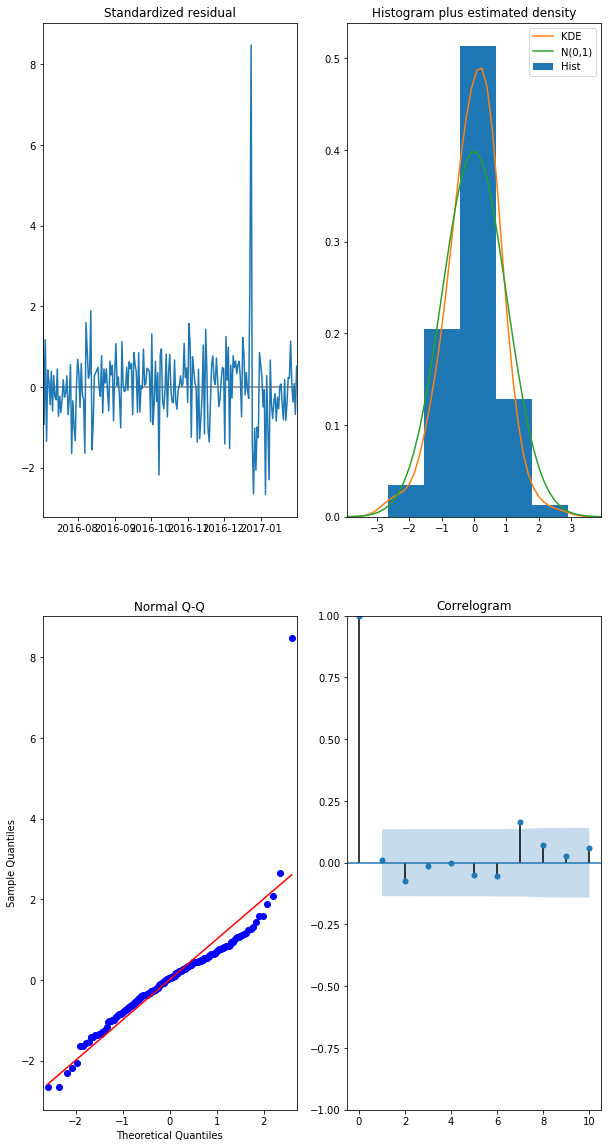

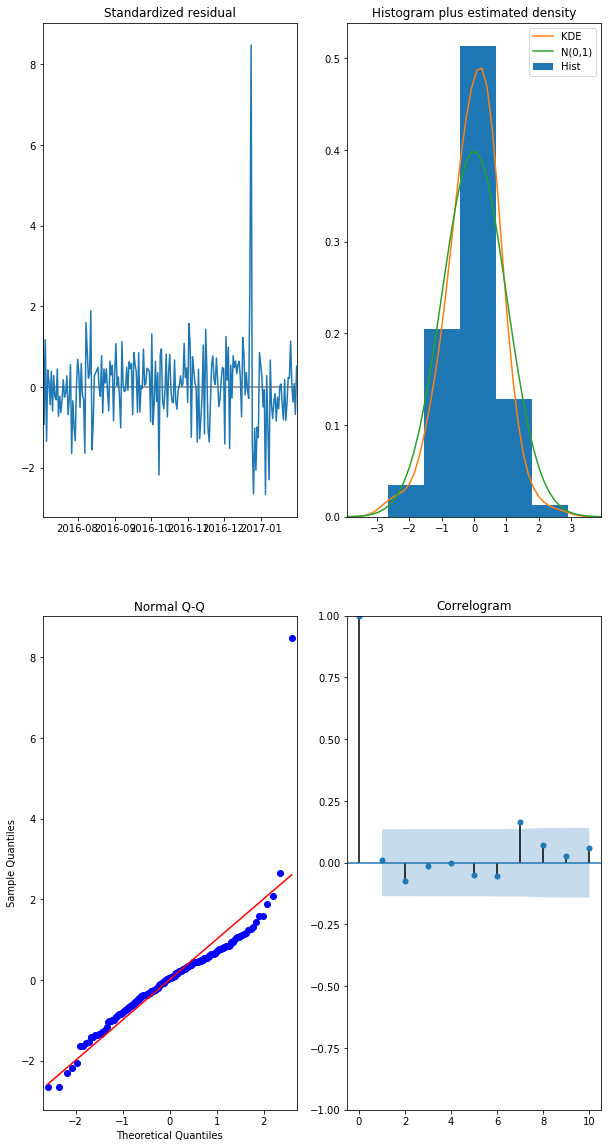

In [638]:
params = (1,1,1,1,1,1,1,"c")
sarimax_model = SARIMAX(endog=data[endog_col],exog=data[exog_col],\
                               order=(int(params[0]),int(params[1]),int(params[2])),\
                                        seasonal_order=(int(params[3]),int(params[4]),\
                                                        int(params[5]),int(params[6])),\
                                        trend=params[7], mle_regression=True, \
                                        enforce_invertibility=False)
results_object1 = sarimax_model.fit(maxiter=1000,method="bfgs",\
                                         return_params=False)
results_object1.plot_diagnostics(figsize=(10,20))

In [192]:
data_11 = train_dict["air_08f994758a1e76d4.csv"]
sarimax_mod = SARIMAX(endog=data[endog_col],exog=data[exog_col],\
                           order=(int(params[0]),int(params[1]),int(params[2])),seasonal_order=(int(params[3]),int(params[4]),int(params[5]),int(params[6])),\
                                    trend=params[7], mle_regression=True, enforce_invertibility=False)

results_11 = sarimax_mod.fit()
# results_11.summary()
results_11.predict(start = 173, end=197, dynamic=True, exog=val_dict["air_08f994758a1e76d4.csv"][exog_col])


/Users/derin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


visit_date
2016-07-22    33.043888
2016-07-23    20.446735
2016-07-24    15.000944
2016-07-26    27.794426
2016-07-27    28.347727
2016-07-28    28.787971
2016-07-29    35.387895
2016-07-30    18.723270
2016-07-31    13.559051
2016-08-02    24.912403
2016-08-03    28.328755
2016-08-04    29.461953
2016-08-05    34.354860
2016-08-06    19.480028
2016-08-07    14.126516
2016-08-09    25.822835
2016-08-10    28.447730
2016-08-11    24.394505
2016-08-12    35.280187
2016-08-13    15.795305
2016-08-17    26.287391
2016-08-18    28.939672
2016-08-19    34.485609
2016-08-20    20.896161
2016-08-21    14.790032
dtype: float64

In [193]:
true = np.array(val_dict["air_08f994758a1e76d4.csv"]["visitors"])
pred = np.array(results_11.predict(start = 173, end=197, dynamic=True, exog=val_dict["air_08ef81d5b7a0d13f.csv"][exog_col]))

In [194]:
np.divide(np.abs(np.subtract(true[:24],pred[:24])), np.abs(true[:24]))

array([ 0.02812093,  0.07614396,  0.28566933,  0.98531615,  1.18059439,
        0.02814182,  0.04082045,  0.06383652,  0.74416884,  0.28821706,
        0.66639737,  1.45516273,  0.01043705,  0.37161201,  0.45667246,
        0.51899032,  0.23114242,  0.4349709 ,  7.82004663,  0.6566238 ,
        0.17851903,  0.07183971,  0.11575361,  0.49033753])

In [198]:
for param in grid: 
    if param in list(grid_model_params.keys()):
        param_data = pd.DataFrame(grid_model_params[param])
        param_data.to_csv("param_grid_csv/" + str(param) + ".csv")